# CA - TensorFlow

Using trained and pretrained ML models to predict the Fashion MNIST data set which consists of 70,000 grayscale images, each with dimensions of 28 × 28 pixels that has been split into  a training dataset (60,000 images) and test dataset (10,000 images).   

Each image depicts a fashion product from one of the following 10  categories:  
`0`: T-shirt/top `1`: Trouser `2`: Pullover `3`: Dress `4`: Coat `5`: Sandal `6`: Shirt `7`: Sneaker `8`: Bag `9`: Ankle boot


This workbook contains Part 3 and 4 of the CA and each section has been titled to reflect which part of the specification it  refers to.

In [1]:
import os
import warnings
# Suppress informational startup messages from TensorFlow and protobuf (missing GPU drivers and minor version mismatches)
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from google.cloud import aiplatform

In [2]:
# Set Seed for reproducable results
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Paths to test and train data
DATA_ROOT = "/home/jupyter/fmnist-dataset"       
TEST_DIR  = os.path.join(DATA_ROOT, "test")
TEST_CSV  = os.path.join(DATA_ROOT, "test.csv")
TRAIN_DIR  = os.path.join(DATA_ROOT, "train")
TRAIN_CSV  = os.path.join(DATA_ROOT, "train.csv")

# map label value (index) to name
CLASS_NAMES = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

# Part 3 - Coding 

## Deployed Model (Task 3.1)

### Set up endpoint access

In [3]:
PROJECT_ID  = "w1-ek506"     
REGION = "us-central1"        
ENDPOINT_ID = "1611592675738255360"   

aiplatform.init(project=PROJECT_ID, location=REGION)

endpoint = aiplatform.Endpoint(
    endpoint_name=f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
)

print("Endpoint resource name:", endpoint.resource_name)

Endpoint resource name: projects/834307845345/locations/us-central1/endpoints/1611592675738255360


### Pre-process images

Using fmnist-dataset, convert to a list 'x_test' of test images where each instance has the following characteristics:  
– Type: list  
– Shape: (28,28)  
– Value type: float32  
– Value range: 0...1  

In [4]:
def load_split_jpg(img_dir, csv_path):
    """
    Load grayscale 28×28 images and labels from a folder and CSV.

    Parameters:
        img_dir (str): Path to image directory.
        csv_path (str): Path to CSV with 'filename' and 'label' columns.

    Returns:
        X (np.ndarray): Normalized image array of shape (N, 28, 28).
        y (np.ndarray): Integer label array of shape (N,).
    """
    df = pd.read_csv(csv_path)
    
    X, y = [], []
    for i, row in df.iterrows():
        img_name = row["filename"]
        label = int(row["label"])
        fp = os.path.join(img_dir, img_name)

        # open image, convert to grayscale, normalise to [0,1]
        with Image.open(fp).convert("L") as im:
            arr = np.array(im, dtype=np.float32) / 255.0
            # ensure consistent shape (28,28)
            if arr.shape != (28, 28):
                arr = np.array(im.resize((28, 28)), dtype=np.float32) / 255.0
        X.append(arr)
        y.append(label)
        
        if (i + 1) % 5000 == 0:
            print(f"Processed {i + 1} images")

    
    X = np.stack(X, axis=0)          
    y = np.array(y, dtype=np.int64)   
    return X, y

Processed 5000 images
Processed 10000 images
X_test: (10000, 28, 28) float32 [0.000,1.000]
y_test: (10000,) int64


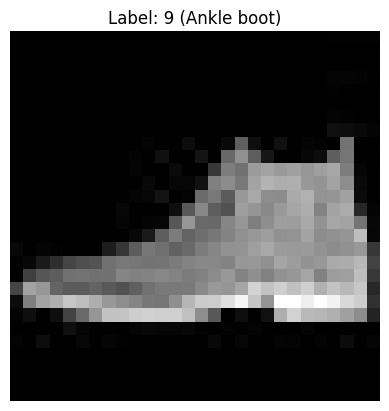

In [5]:
# Process test dataset
X_test, y_test = load_split_jpg(TEST_DIR, TEST_CSV)   
print("X_test:", X_test.shape, X_test.dtype, f"[{X_test.min():.3f},{X_test.max():.3f}]")
print("y_test:", y_test.shape, y_test.dtype)

# Show example of input data in X_test
plt.imshow(X_test[0], cmap="gray"); plt.title(f"Label: {y_test[0]} ({CLASS_NAMES[y_test[0]]})")
plt.axis("off")
plt.show()

### Make predictions with deployed model

I have saved the results of the y_hat_endpoint variable as a .npy file so the notebook can be run without redeploying the model.  
* If the model is currently deployed, use code below to make predictions
* Otherswise use following cell to load y_hat_endpoint.npy file with previously run predictions

In [ ]:
# Run if model is deployed to endpoint
def vertex_predict_batch(endpoint, X, batch_size=128):
    """
    Run batched predictions on input data using a Vertex AI endpoint.

    Parameters:
        endpoint: Vertex AI endpoint with a .predict() method.
        X (np.ndarray): Input array of shape (N, ...) to predict on.
        batch_size (int): Number of instances per prediction batch.

    Returns:
        np.ndarray: Predicted class indices of shape (N,).
    """
    all_preds = []
    n = X.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = X[start:end]
        instances = batch.tolist()  # JSON-serialisable
        resp = endpoint.predict(instances=instances)
        scores = np.array(resp.predictions)  # shape ~ (B, 10)
        preds = scores.argmax(axis=1)
        all_preds.append(preds)
        print(f"Predicted {end}/{n}")
    return np.concatenate(all_preds, axis=0)

y_hat_endpoint = vertex_predict_batch(endpoint, X_test, batch_size=128)
print("Predictions:", y_hat_endpoint.shape)

# Save after making predictions
np.save("/home/jupyter/y_hat_endpoint.npy", y_hat_endpoint)

In [6]:
# Run if model is not deployed to endpoint, can use .npy file to get results from previous run
y_hat_endpoint = np.load("/home/jupyter/y_hat_endpoint.npy")

## Local Workbench model (Task 3.2)

### Load Model

In [7]:
MODEL_PATH = "/home/jupyter/fashion-mnist2"
loaded = tf.saved_model.load(MODEL_PATH)

In [8]:
# Inspect available model signatures and input/output formats
print("Available signatures:", list(loaded.signatures.keys()))

for name, fn in loaded.signatures.items():
    print(f"\nSignature name: {name}")
    print("Inputs:", fn.structured_input_signature)
    print("Outputs:", fn.structured_outputs)


Available signatures: ['serving_default']

Signature name: serving_default
Inputs: ((), {'flatten_input': TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='flatten_input')})
Outputs: {'dense_1': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_1')}


### Make predictions

In [9]:
sig = loaded.signatures["serving_default"]
outs = sig(flatten_input=tf.constant(X_test))
y_scores_local = outs['dense_1'].numpy()
y_hat_local = y_scores_local.argmax(axis=1)

print("Predictions extracted. Shape:", y_hat_local.shape)

Predictions extracted. Shape: (10000,)


## Evaluate Deployed vs Local Models (Task 3.3)

In [10]:
# Accuracy
acc_local     = accuracy_score(y_test, y_hat_local)
acc_endpoint  = accuracy_score(y_test, y_hat_endpoint)

# F1 (macro and micro averages)
f1_local_macro     = f1_score(y_test, y_hat_local, average="macro")
f1_local_micro     = f1_score(y_test, y_hat_local, average="micro")
f1_endpoint_macro  = f1_score(y_test, y_hat_endpoint, average="macro")
f1_endpoint_micro  = f1_score(y_test, y_hat_endpoint, average="micro")

print(f"Local model     — Accuracy: {acc_local:.4f} | F1(macro): {f1_local_macro:.4f} | F1(micro): {f1_local_micro:.4f}")
print(f"Deployed model  — Accuracy: {acc_endpoint:.4f} | F1(macro): {f1_endpoint_macro:.4f} | F1(micro): {f1_endpoint_micro:.4f}")


Local model     — Accuracy: 0.8803 | F1(macro): 0.8799 | F1(micro): 0.8803
Deployed model  — Accuracy: 0.8779 | F1(macro): 0.8779 | F1(micro): 0.8779


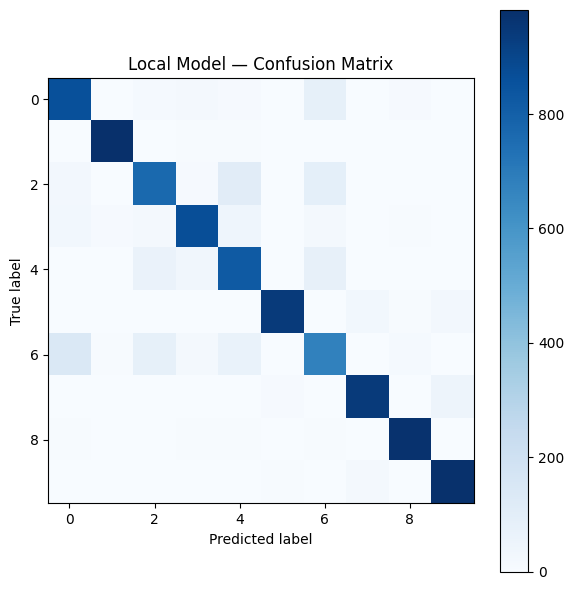

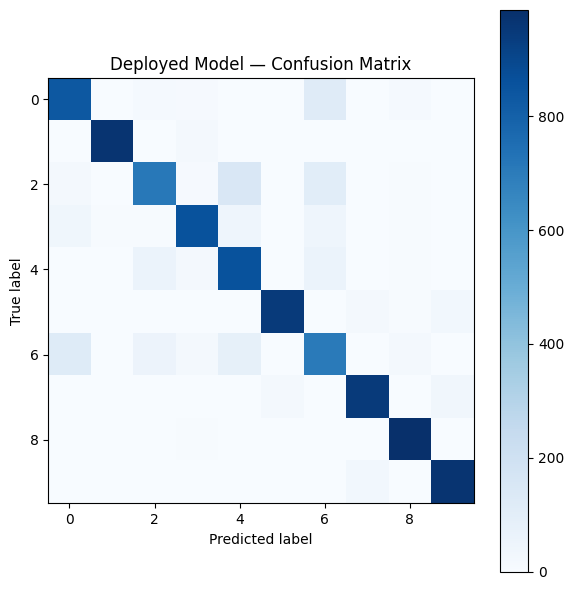

In [11]:
# Plot Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return cm

cm_local    = plot_confusion(y_test, y_hat_local, "Local Model — Confusion Matrix")
cm_endpoint = plot_confusion(y_test, y_hat_endpoint, "Deployed Model — Confusion Matrix")


In [12]:
# Per class accuracy
per_class_acc_local    = np.diag(cm_local) / np.sum(cm_local, axis=1)
per_class_acc_endpoint = np.diag(cm_endpoint) / np.sum(cm_endpoint, axis=1)

df_compare = pd.DataFrame({
    "Class": CLASS_NAMES,
    "Local Accuracy": per_class_acc_local,
    "Deployed Accuracy": per_class_acc_endpoint
})

df_compare["Δ Accuracy (Deployed - Local)"] = df_compare["Deployed Accuracy"] - df_compare["Local Accuracy"]
df_compare

,Class,Local Accuracy,Deployed Accuracy,Δ Accuracy (Deployed - Local)
0,T-shirt/top,0.861,0.835,-0.026
1,Trouser,0.982,0.968,-0.014
2,Pullover,0.765,0.710,-0.055
3,Dress,0.870,0.859,-0.011
4,Coat,0.822,0.856,0.034
5,Sandal,0.940,0.947,0.007
6,Shirt,0.674,0.702,0.028
7,Sneaker,0.942,0.947,0.005
8,Bag,0.972,0.987,0.015
9,Ankle boot,0.975,0.968,-0.007


In [13]:
# Average difference in class accuracy
np.mean(abs(df_compare["Δ Accuracy (Deployed - Local)"]))

0.020200000000000006

In [14]:
# Classification Report
print("Local model classification report:\n",
      classification_report(y_test, y_hat_local, target_names=CLASS_NAMES))
print("\nDeployed model classification report:\n",
      classification_report(y_test, y_hat_endpoint, target_names=CLASS_NAMES))

Local model classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.86      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.81      0.77      0.79      1000
       Dress       0.90      0.87      0.89      1000
        Coat       0.78      0.82      0.80      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.71      0.67      0.69      1000
     Sneaker       0.95      0.94      0.95      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.93      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Deployed model classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.82      0.83      0.83      1000
     Trouser       0.99      0.97      0.98      1000
  

## Differences between Models (Task 3.4)

Overall, both models show very similar performance, local model with 0.8803 accuracy, deployed model with 0.8779 accuracy. They also show similar behaviour with individual class accuracy where the average difference of class accuracy between the two models is 0.02 and the biggest difference is only 0.055 for pullovers where the local model performed slightly better. The F1 scores for both models also show their similarity with 7 identical class scores and all class scores withitin 0.02 when comparing the two models. Both models were best at predicting Trouser, Bag, Ankel boot, Sneaker and Sandal with f1 scores > 0.95 for both models and worst at predicting T-shirt/top, Pullover, Coat and Shirt with Shirt having a muuch lower f1 score of 0.69 in both models. It can been seen in the confusion matricies that both models often misclassify the visually similar items (T-shirt/top, Pullover, Coat or Shirt) as one another which would be explained by their visual similarity  whereas the items with a more distinct shape such as trousers scored very well. 
  
The small differences in these models could be explained by different hyperparameters such as a different learning rate, batch size or number of epochs which could cause the model to converge to a marginally different set of weights.  In addition, slight model export and deployment factors such as numerical precision (float32 vs float64) and model optimisation could contribute to minor variations between the two models.  
  
In conclusion, both models demonstrate near identical results on the dataset with the local model performing slightly better. The deployed model offers scalability and easy integration into production systems, while the local model provides faster results as it doesn't require the  model to be depolyed.


# Part 4 - Machine Learning

## Train NN model (Task 4.1)

### Data Preprocessing

Preprocess training data using the same load_split_jpg() function as in Task 3.1

Processed 5000 images
Processed 10000 images
Processed 15000 images
Processed 20000 images
Processed 25000 images
Processed 30000 images
Processed 35000 images
Processed 40000 images
Processed 45000 images
Processed 50000 images
Processed 55000 images
Processed 60000 images
X_train: (60000, 28, 28) float32 [0.000,1.000]
y_train: (60000,) int64


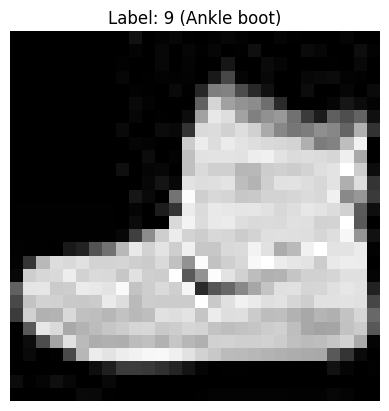

In [15]:
X_train, y_train = load_split_jpg(TRAIN_DIR, TRAIN_CSV)   
print("X_train:", X_train.shape, X_train.dtype, f"[{X_train.min():.3f},{X_train.max():.3f}]")
print("y_train:", y_train.shape, y_train.dtype)

# Add extra channel for conv layers if needed
if X_train.ndim == 3:  # shape (N, 28, 28)
    X_train = X_train[..., None]  
if X_test.ndim == 3:  # shape (N, 28, 28)
    X_test = X_test[..., None] 


# Example of input data in X_test
plt.imshow(X_train[0], cmap="gray"); plt.title(f"Label: {y_train[0]} ({CLASS_NAMES[y_train[0]]})")
plt.axis("off")
plt.show()

### Hyperparameter Tuning

I have chosen to use a simple CNN architecutre and tune the following hyperparameters
* Number of filters in convolutional layers (conv1_filters, conv2_filters)
* Size of the dense layer (dense_units)
* Dropout rate (dropout)
* Learning rate (learning_rate)

I am using the sparse_categorical_crossentropy loss function as this is an integer labeled multi-class classification problem, and measuring using accuracy with a 10% validation split. To reduce search complexity I have fixed the optimiser to Adam and batch size to 128  as these are popular defaults for image classification tasks.    
I am using the Keras Hyperband algorithm for my tuning proccess as it only trains models for a few epochs before discarding poor performers and continuing with the better models. I have also implemented early stopping during tuning to halt and restore the best weights if validation accuracy does not improve for 2 consecutive epochs, which will help reduce the tuning time and prevent overfitting.  
I chose a simple CNN architecture with dropout regularization to prevent overfitting, as Fashion MNIST is a simple classification task with low-resolution grayscale inputs.

In [16]:
def build_model(hp):
    """
    Build a CNN model for image classification with tunable hyperparameters.

    Parameters:
        hp: HyperParameters object from Keras Tuner used to select values.

    Returns:
        tf.keras.Model: Compiled Keras model with selected architecture and optimizer settings.
    """

    # Tune number of filters
    conv1_filters = hp.Choice('conv1_filters', [32, 64])
    conv2_filters = hp.Choice('conv2_filters', [64, 128])
    # Tune dense layer size
    dense_units = hp.Choice('dense_units', [64, 128, 256])
    # Tune dropout
    dropout = hp.Choice('dropout', [0.2, 0.3, 0.4])
    
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(conv1_filters, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(conv2_filters, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    # Tune learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Define tuner (saves results to /quick_tune/fmnist
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=7,
    factor=3,
    directory='quick_tune',
    project_name='fmnist',
    overwrite=False
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

Reloading Tuner from quick_tune/fmnist/tuner0.json


In [ ]:
# Run Tuning (can skip this cell if tuning has already been run)
tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=128, 
    callbacks=[stop_early],
    verbose=1
)

In [18]:
# Load best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HP:", best_hp.values)

Best HP: {'conv1_filters': 64, 'conv2_filters': 128, 'dense_units': 256, 'dropout': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0004'}


### Build final model

Using the best hyperparameters from the tuning process (best_hp), train the model on more epochs using early stopping on validation accuracy to prevent overfitting. 

In [19]:
best_model = build_model(best_hp)

final_hist = best_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    callbacks=[stop_early],
    verbose=1
)


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step - accuracy: 0.8245 - loss: 0.4876 - val_accuracy: 0.8858 - val_loss: 0.3134
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - accuracy: 0.8874 - loss: 0.3128 - val_accuracy: 0.9012 - val_loss: 0.2691
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 177ms/step - accuracy: 0.9042 - loss: 0.2654 - val_accuracy: 0.9083 - val_loss: 0.2471
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 76s 180ms/step - accuracy: 0.9145 - loss: 0.2341 - val_accuracy: 0.9097 - val_loss: 0.2512
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 76s 180ms/step - accuracy: 0.9226 - loss: 0.2093 - val_accuracy: 0.9155 - val_loss: 0.2383
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 178ms/step - accuracy: 0.9297 - loss: 0.1887 - val_accuracy: 0.9183 - val_loss: 0.2274
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 177ms/step - accuracy: 0.9365 - loss: 0.1709 - val_accuracy: 0.9222 - val_loss: 0.2308
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - accuracy: 0.9447 - loss: 0

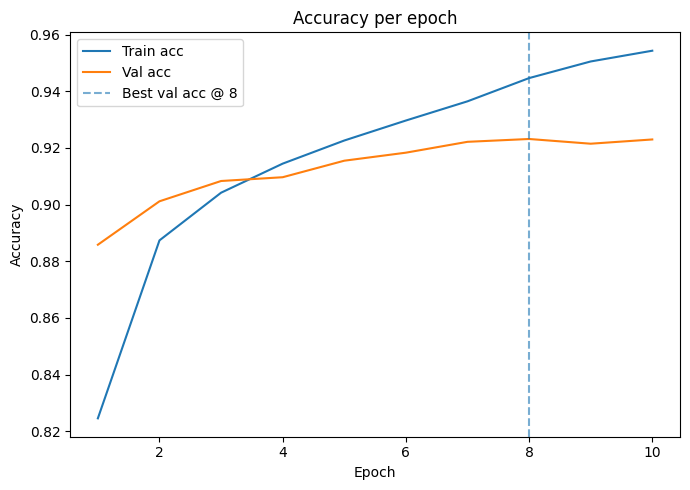

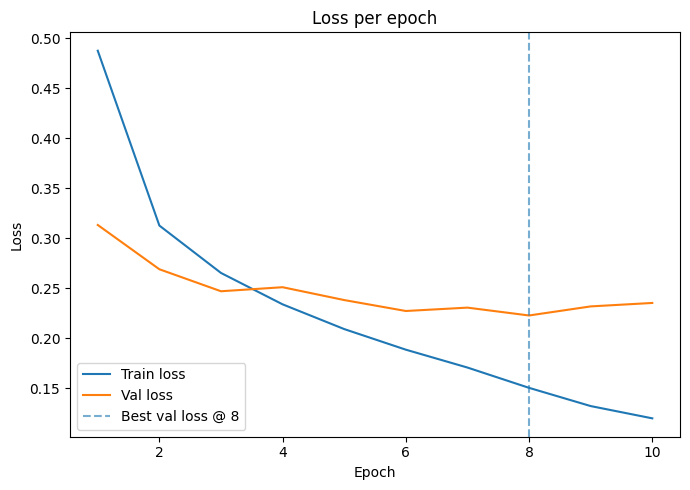

Best val_accuracy at epoch 8: 0.9232
Best val_loss     at epoch 8: 0.2229


In [20]:
# --- Plot training history ---
hist = final_hist.history
epochs = np.arange(1, len(hist['accuracy']) + 1)

best_val_acc_epoch  = np.argmax(hist['val_accuracy']) + 1
best_val_loss_epoch = np.argmin(hist['val_loss']) + 1

# Accuracy plot
plt.figure(figsize=(7,5))
plt.plot(epochs, hist['accuracy'], label='Train acc')
plt.plot(epochs, hist['val_accuracy'], label='Val acc')
plt.axvline(best_val_acc_epoch, ls='--', alpha=0.6, label=f'Best val acc @ {best_val_acc_epoch}')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(7,5))
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.axvline(best_val_loss_epoch, ls='--', alpha=0.6, label=f'Best val loss @ {best_val_loss_epoch}')
plt.title('Loss per epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout()
plt.show()

print(f"Best val_accuracy at epoch {best_val_acc_epoch}: {hist['val_accuracy'][best_val_acc_epoch-1]:.4f}")
print(f"Best val_loss     at epoch {best_val_loss_epoch}: {hist['val_loss'][best_val_loss_epoch-1]:.4f}")


### Evaluate model 

In [21]:
y_hat_trained = best_model.predict(X_test).argmax(axis=1)

acc_trained = accuracy_score(y_test, y_hat_trained)
f1_trained_macro = f1_score(y_test, y_hat_trained, average="macro")
f1_trained_micro = f1_score(y_test, y_hat_trained, average="micro")

print(f"Trained model   — Accuracy: {acc_trained:.4f} | F1(macro): {f1_trained_macro:.4f} | F1(micro): {f1_trained_micro:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Trained model   — Accuracy: 0.9172 | F1(macro): 0.9156 | F1(micro): 0.9172


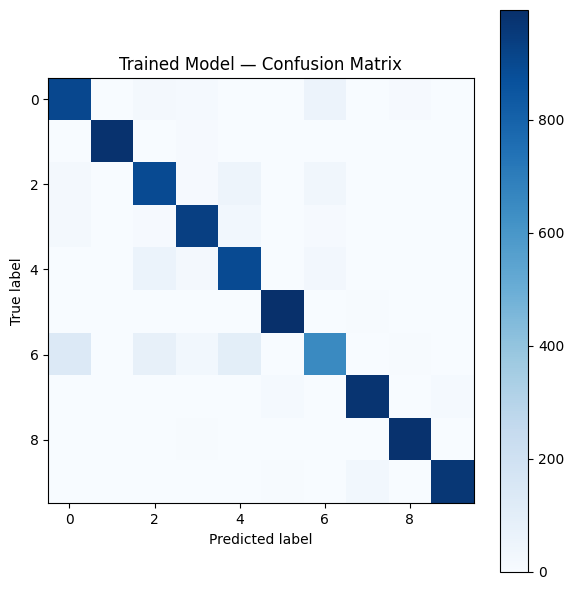

In [ ]:
cm_trained = plot_confusion(y_test, y_hat_trained, "Trained Model — Confusion Matrix")

In [23]:
per_class_acc_trained = np.diag(cm_trained) / np.sum(cm_trained, axis=1)

CLASS_NAMES = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

df_trained_compare = pd.DataFrame({
    "Class": CLASS_NAMES,
    "Trained Model Accuracy": per_class_acc_trained
})

df_trained_compare



,Class,Trained Model Accuracy
0,T-shirt/top,0.902
1,Trouser,0.986
2,Pullover,0.893
3,Dress,0.934
4,Coat,0.891
5,Sandal,0.994
6,Shirt,0.649
7,Sneaker,0.975
8,Bag,0.985
9,Ankle boot,0.963


In [24]:
print("Trained model classification report:\n",
      classification_report(y_test, y_hat_trained, target_names=CLASS_NAMES))

Trained model classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.90      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.84      0.89      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.84      0.89      0.86      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.84      0.65      0.73      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Model Accuracy, Stength and Weaknesses

On the test dataset, the model achieved an overall accuracy of 0.9172, indicating that it generalized well and was not significantly overfitted to the training data. It demonstrated particularly high accuracy in predicting Trouser, Sandal, Sneaker, Bag, and Ankle boot, each with class-wise accuracy exceeding 0.96. The lowest-performing class was Shirt, with an accuracy of 0.649. The F1 scores reflected a similar pattern: Trouser, Sandal, Sneaker, Bag, and Ankle boot all achieved F1 scores above 0.97, while Shirt scored only 0.73. The model had difficultly distinguishing between visually similar items (Shit, Coat, Pullover, T-shirt/top, dress) which is shown in the confusion matrix where almost all misclassifications are between these classes. However the model performed exeptionally with the distict shaped items (Trouser, Sandal, Sneaker, Bag and Ankle boot).  

Given the scope of this coursework I am satisfied with a test accuracy of 92% but if I needed to achieve a higher accuracy I would experiment with different model architecutes with varied layer types, depths, and neuron counts. I would also implement data augmentation to increase the training data size and to help the model generalize better. I could also implement more dropout layers or L2 regularization to prevent overfitting during training. 

### Comparing with pre-trained models (Task 4.2)

The trained model achieved a test accuracy of 0.92, outperforming both the local and deployed pretrained models, which each had a test accuracy of 0.88. It shows a higher accuracy across almost all classes, especially those where the previous models performed poorer on (pullover, Shirt, Coat) with the largest increase being +0.128 for Pullover that went from 0.765 to 0.893. The F1 scores also show increases in almost all categories for the trained model compared to the best of either pre-trained models such as Pullover scoring 0.87 compared to 0.79 and Sandal scoring 0.99 compared to 0.96. While Shirt remained the weakest class across all models, the trained model still improved its F1 score to 0.73 from 0.69. As seen in the confusion matrix, the trained model classifies the visually similar items with better precision that the pretrained models.     
Overall, the trained model outperformed both trained models demonstrating stronger generalization and better class balance. This comparison highlights the value of task-specific training and tuning, showing that models trained from scratch can outperform generic pre-trained models when optimized effectively.


### Export Model (Task 4.3)

In [25]:
export_path = "fashion-mnist-trained.keras"
best_model.save(export_path)


print(f"Model successfully exported to: {export_path}")

Model successfully exported to: fashion-mnist-trained.keras
